In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

# Plotting TODO: 
# standardize Y axes per section so the visual comparison can be easier
# draw horizontal lines at 0 for the learning progress section
# disentangle with gray lines learning progress series for better visualization
# Add interaction to the windows

## Preprocessing

In [4]:
#A13OOAT2ORKH6V:3EWIJTFFVPMYW8IUWPUOOQWSVFU0E8,1,1,2937,Bear_4_2,Bear,category2D,pancakes,waffles,False,6032
#participant:assignmentId,trial,blockTrial,trialStartTime,monster,family,category,preferredFood,choice,correct,rt

def stringToInt(arr, position, values):
    for i, v in enumerate(values):
        arr[arr[:,position] == v, position] = i
    return arr

#csvFile = 'data/test.csv'
csvFile = 'data/monsters_data_pilot_041417.csv'

# Get all columns
#csv = np.genfromtxt(csvFile, dtype=np.string_, delimiter=',', skip_header=1)
# Only id(0), category(6), correct(9) 
csv = np.genfromtxt(csvFile, dtype=np.string_, delimiter=',', usecols=(0,6,9), skip_header=1)

# Pre-process CSV
# Get categories
categories = [c for c in np.unique(csv[:,1])]
# Get unique ids
ids = [i for i in np.unique(csv[:,0]) ]
# For converting string to int boolean
bo = [b'False', b'True']

csvInt = csv.copy()
# Convert fields to ints for easy processing
for i,j in enumerate([ids, categories, bo]):
    csvInt = stringToInt(csvInt, i, j)
csvInt = csvInt.astype('int')

# Split by user
splitCsv = [csvInt[csvInt[:,0]==i] for i in np.unique(csvInt[:,0])]

## Action selection trajectories

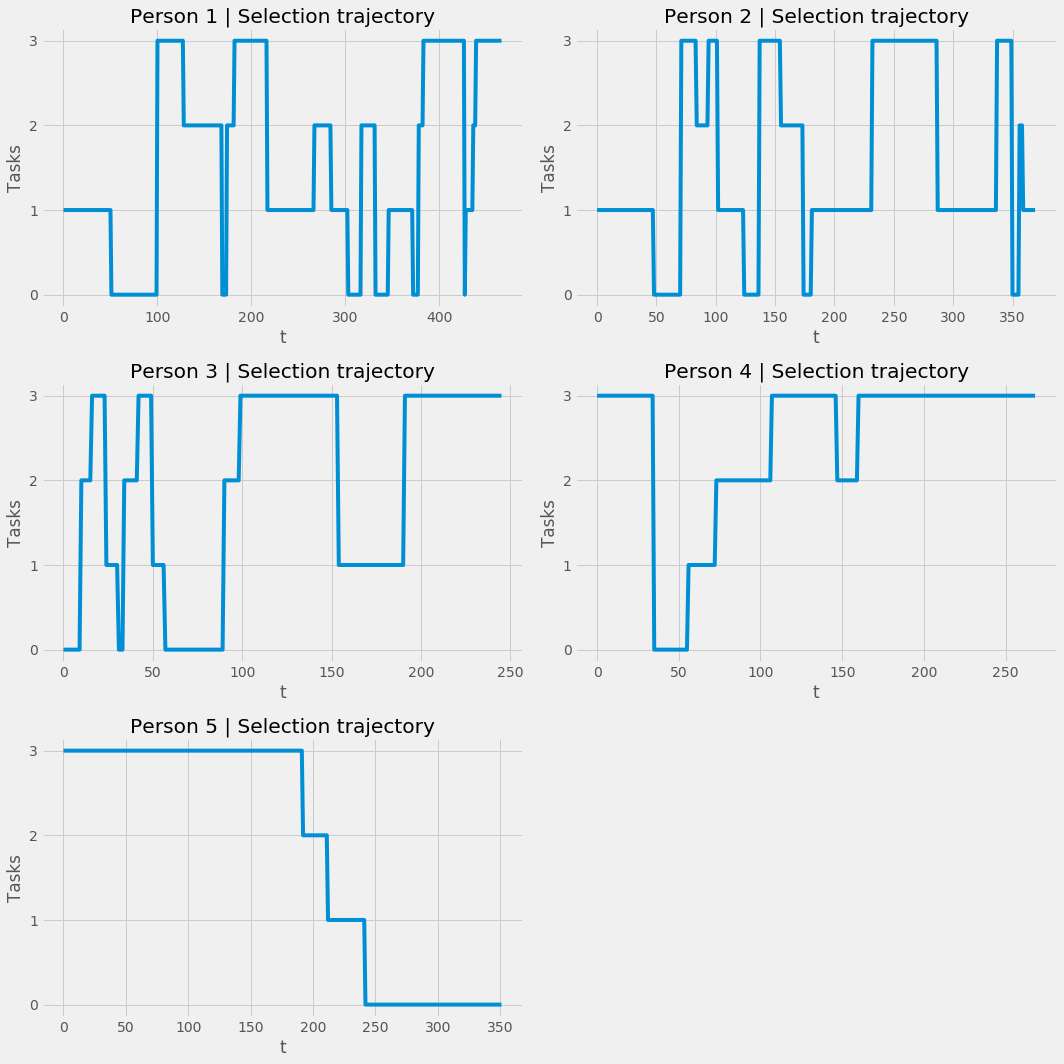

In [10]:
users = 5

fig = plt.figure(figsize=(15, 15))
# Set up subplots
ax, c = [], 0
for i in range(3):
    for j in range(2):
        ax.append(plt.subplot2grid((3, 2), (i, j)))
        c+=1
        if c == users:
            break
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
for u in range(users):
    ax[u].plot(splitCsv[u][:,1])
    ax[u].set_title(''.join(['Person ', str(u+1), ' | Selection trajectory']))
    ax[u].set_yticks([0,1,2,3])
    ax[u].set_ylabel('Tasks')
    ax[u].set_xlabel('t')

plt.tight_layout()
#plt.savefig('trajectories.pdf')
    
plt.show()

## Cumulative action-selection

Number of occasions a task has been selected at a specific point in time

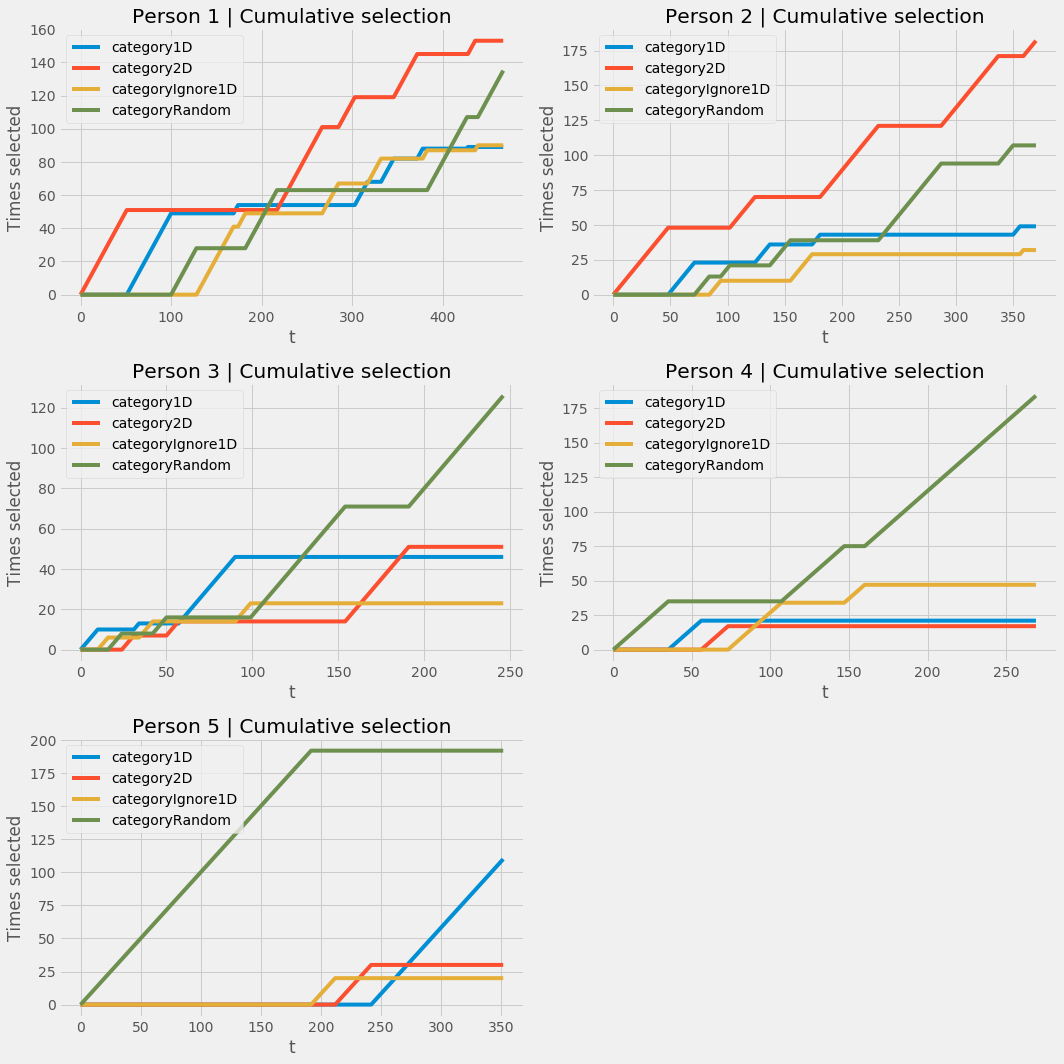

In [11]:
tasks = 4
categories = ['category1D', 'category2D', 'categoryIgnore1D', 'categoryRandom']

# Count at each point in time number of occurrences up to that point and save it into a list
def countInTime(arr, numOfValues):
    counts = []
    for i in range(len(arr)+1):
        count = [(arr[:i] == e).sum() for e in range(numOfValues)]
        counts.append(count)
    return np.array(counts).T

fig = plt.figure(figsize=(15, 15))
# Set up subplots
ax, c = [], 0
for i in range(3):
    for j in range(2):
        ax.append(plt.subplot2grid((3, 2), (i, j)))
        c+=1
        if c == users:
            break
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
cumCounts = []
for u in range(users):
    # Cumulative count for user u per task
    cumCounts.append( countInTime(splitCsv[u][:,1], tasks) )
    # Plot cumulative counts per task for this user u only
    for t in range(tasks):
        ax[u].plot(cumCounts[u][t,:], label=categories[t])
    ax[u].legend()
    ax[u].set_title(''.join(['Person ', str(u+1), ' | Cumulative selection']))
    ax[u].set_ylabel('Times selected')
    ax[u].set_xlabel('t')

plt.tight_layout()
plt.show()

Attracted to max entropy/surprisal/uncertainty over medium complexity?

## Error (based on accuracy)

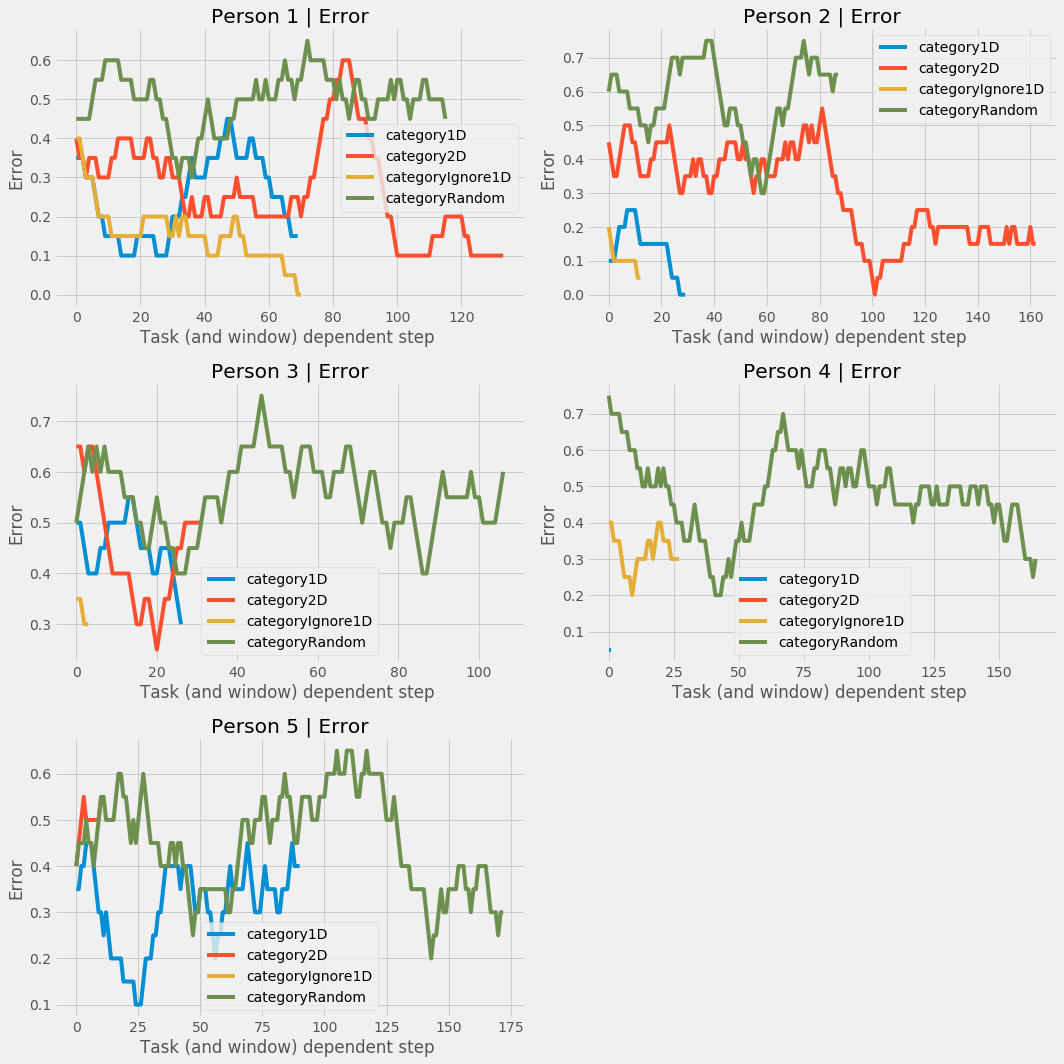

In [14]:
# Controls moving average window (So window=1 means average with nothing else but itself)
window = 20

fig = plt.figure(figsize=(15, 15))
# Set up subplots
ax, c = [], 0
for i in range(3):
    for j in range(2):
        ax.append(plt.subplot2grid((3, 2), (i, j)))
        c+=1
        if c == users:
            break
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
errors=[]
for u in range(users):
    # With a list in case I want to store them like cumCounts, movAvg should be moved out of this loop though
    # To be indexed by user too
    movAvg=[]
    # Plot error moving average per task for this user u only
    for t in range(tasks):
        # e = 1-accuracy (where accuracy)
        movAvg.append(1-pd.rolling_mean(splitCsv[u][splitCsv[u][:,1]==t, 2], window)[window-1:])
        ax[u].plot(movAvg[t], label=categories[t])
    errors.append(movAvg)
    ax[u].legend()
    ax[u].set_title(''.join(['Person ', str(u+1), ' | Error']))
    ax[u].set_ylabel('Error')
    ax[u].set_xlabel('Task (and window) dependent step ')

plt.tight_layout()
plt.show()


## Learning Progress ($n$ back step smoothing version)

It is calculated on the smoothed out error time series from the previous section. Thus parameter window indirectly tunes it too.

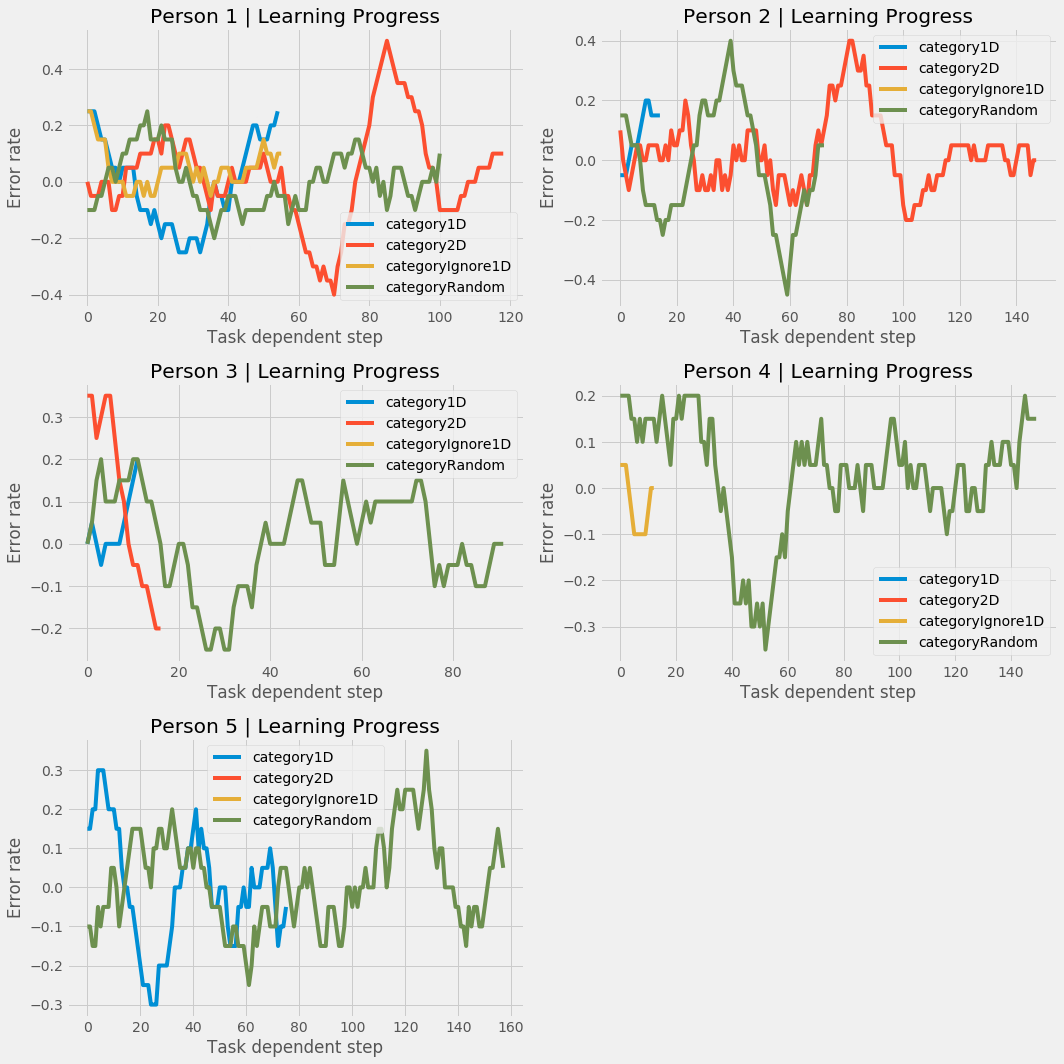

In [15]:
#lp[t] = - [ err[t] - err[t-lookback] ] (Errors are not averaged for now (not enough points in some cases!!!))
lookback = 15

def errorChange(arr, window=1, getInitDiff=True):
    # Reverse it
    arr = arr[::-1]
    # LP = - [error(now) - error(past)]
    # window: a look-back to consider the difference  diff[t] = a[t] - a[t-window]
    lp = [-i+j for i, j in zip(arr[:-window], arr[window:])]
    # if it's set to true then it will append the initial (noisy) differences that were left behind by the nature
    # of having a rolling window. Thus it will calculate the differences (only one step) and append them
    if getInitDiff:
        lp += np.diff(arr[-window:]).tolist()
    # Reverse it
    lp = lp[::-1]
    return lp

fig = plt.figure(figsize=(15, 15))
# Set up subplots
ax, c = [], 0
for i in range(3):
    for j in range(2):
        ax.append(plt.subplot2grid((3, 2), (i, j)))
        c+=1
        if c == users:
            break
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for u in range(users):
    lpT = []
    for t in range(tasks):
        lpT.append( errorChange(errors[u][t], window=lookback, getInitDiff=False) )
        # If i make errorChange multidimensional
        #ax[u].plot(lpT[u][t], label=categories[t])
        ax[u].plot(lpT[t], label=categories[t])
        # TODO: adjust so it start at 0 when getInitDiff=true
        #ax[u].plot([x for x in range(lookback,lookback+len(lpT))], lpT)
    ax[u].legend()
    ax[u].set_title(''.join(['Person ', str(u+1), ' | Learning Progress']))
    ax[u].set_ylabel('Error rate')
    ax[u].set_xlabel('Task dependent step')
    
    ax[u].axhline(y=0,xmin=0,xmax=1,c="black",linewidth=0.5,zorder=0)

plt.tight_layout()
plt.show()